In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

SystemExit: error: [Errno 13] Permission denied: '/usr/lib/python3.8/site-packages/PyRoss-1.0.0-py3.8.egg-info'

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
print(N)
fi = Ni/N 

64111602.0


In [3]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
N = N/5e2
Ni = Ni/5e2

In [4]:
# Generate class with contact matrix for SIR-type model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

In [5]:
times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.6, 0.6

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [6]:
beta  = 0.04         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 


# initial conditions
E0   = np.array([10]*M)
A0   = np.array([10]*M)
Ia0  = np.array([10]*M)# each age group has asymptomatic infectives
Is0  = np.array([10]*M)# and also symptomatic infectives
Ih0  = np.array([10]*M)
Ic0  = np.array([10]*M)
Im0  = np.array([2]*M)
R0   = np.zeros(M)
S0   = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni)
print(Ni)

#def contactMatrix(t):
#    if t < 20:
#        return CH + CS + CW + CO
#    else:
#        return CH + aS*CS + aW*CW + aO*CO


# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, C, Tf, Nf)

[31268.886 35668.366 35526.088 25759.864]


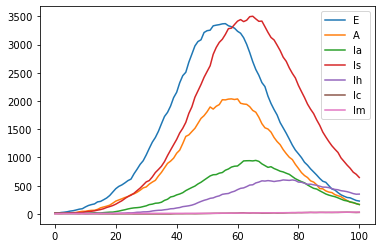

In [7]:
## Save pre intervention traj
Tf = 19 
Nf = Tf+1
np.save('pre_intervention_traj_SEAI5R.npy', data['X'][:Nf,:])

# plot the stochastic solution 
plt.plot(data['X'][:, M], label='E')
plt.plot(data['X'][:, 2*M], label='A')
plt.plot(data['X'][:, 3*M], label='Ia')
plt.plot(data['X'][:, 4*M], label='Is')
plt.plot(data['X'][:, 5*M], label='Ih')
plt.plot(data['X'][:, 6*M], label='Ic')
plt.plot(data['X'][:, 7*M], label='Im')
plt.legend()
plt.show()

In [8]:
Tf = 20 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = data['X']
x = (x/N)[:Nf,:8*M]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, generator.constant_CM)
end_time = time.time()
print(logp) 
print(end_time - start_time)

#plt.plot(x[:, M])
#plt.show()

-6298.480365782506
15.166160821914673


In [ ]:
#### infer the parameters from the initial part of the trajectory

# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
obs=x[:20] ## up to intervention time
x0 = x[0]

## guesses for params
alpha_g = 0.4          
beta_g  = 0.03         
gIa_g   = 1./7            
gIs_g   = 1./7   
gE_g    = 1/5
gA_g    = 1/3

S0_g = S0/N
E0_g = E0/N
A0_g  = A0/N
Ia0_g = Ia0/N
Is0_g = Is0/N
Ih0_g = Ih0/N
Ic0_g = Ic0/N
Im0_g = Im0/N

# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-3 # the relative tol in (-logp)  

# set up bounds for all the classes
bounds_for_E  = [(1/N, 50/N)]*M 
bounds_for_A  = [(1/N, 50/N)]*M 
bounds_for_Ia = [(0.1/N, 100/N)]*M
bounds_for_Is = [(1/N, 50/N)]*M 
bounds_for_Ih = [(1/N, 50/N)]*M 
bounds_for_Ic = [(1/N, 50/N)]*M 
bounds_for_Im = [(1/N, 50/N)]*M 
bounds_for_S = [(fi[i]-400/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# set up bounds for the rest of the params 
alpha_b = (0.1,0.5)
beta_b  = (eps, 0.06)
gIa_b   = (eps, 0.2)
gIs_b   = (eps, 0.2)
gE_b    = (0.15, 0.25)
gA_b    = (0.3, 0.4)

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])#, *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Ih, *bounds_for_Ic, *bounds_for_Im])
# stds of the model parameters' priors
stds = np.array([0.2*(k[1] - k[0]) for k in bounds])
stds[0] = 0.3 ## make one a bit larger for demonstration

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g])#, *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Ih0_g, *Ic0_g, *Im0_g])
params, nit = estimator.inference(guess, stds, obs, Tf, Nf, generator.constant_CM, bounds=bounds, verbose=True, niter=2, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=357016, Thu Apr 30 22:00:23 2020)


In [ ]:
## calculate hessian
hess = estimator.hessian(params, obs, Tf, Nf, generator.constant_CM)

KeyboardInterrupt: 

Exception ignored in: 'pyross.inference.SIR_type.obtain_log_p_for_traj_red'
Traceback (most recent call last):
  File "pyross/inference.pyx", line 487, in pyross.inference.SIR_type.obtain_full_mean_cov
  File "pyross/inference.pyx", line 469, in pyross.inference.SIR_type.estimate_cond_mean_cov
  File "/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py", line 242, in odeint
    output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,
  File "pyross/inference.pyx", line 462, in pyross.inference.SIR_type.estimate_cond_mean_cov.rhs
  File "pyross/contactMatrix.pyx", line 164, in pyross.contactMatrix.SIR.interventions_temporal.C_func
  File "<__array_function__ internals>", line 2, in argmin
KeyboardInterrupt: 


In [ ]:
# save the parameters 
np.save('optimal_model_param_SEAI5R.npy', params)
np.save('hessian_SEAI5R.npy', hess)

In [ ]:
## Control Code From this point

In [18]:
eps = 1e-3 
start_time = time.time() 

## Use inferred model parameters in the later part of the traj
parameters = estimator.make_params_dict(params)

## guesses and bounds for control parameters
aW_g = 0.5 
aW_bounds = [0.1, 0.8]
aS_g = 0.5
aS_bounds = [0.1, 0.8]
aO_g = 0.5
aO_bounds = [0.1, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = data['X']/N
x = x[22:,:8*M]
Nf = x.shape[0] 
Tf = Nf-1 
times = [Tf+1]

In [13]:
estimator.set_params(parameters) 
params_control, nit = estimator.infer_control(guess, x, Tf, Nf, generator, bounds,
                                  niter=2, eps=eps, verbose=True)

# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params_control) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

# save the parameters 
np.save('inferred_control_params_SEAI5R.npy', params_control)

parameters: [0.55076476 0.55076476 0.55076476]
parameters: [0.53580216 0.54991267 0.5580288 ]
parameters: [0.41151621 0.55192582 0.63935228]
parameters: [0.40823557 0.54793546 0.65040502]
parameters: [0.40747496 0.54536419 0.65348737]
basinhopping step 0: f -24768.6
parameters: [0.45575598 0.53679302 0.59197193]
parameters: [0.46189962 0.55192895 0.61294584]
parameters: [0.45637457 0.55239304 0.61740572]
parameters: [0.40834891 0.54708537 0.651617  ]
parameters: [0.40756177 0.5402122  0.65423455]
parameters: [0.4088229  0.51601262 0.66097442]
parameters: [0.40882863 0.5160127  0.66096628]
basinhopping step 1: f -24768.6 trial_f -24768.6 accepted 1  lowest_f -24768.6
found new global minimum on step 1 with function value -24768.6
parameters: [0.40277459 0.54986554 0.65836181]
parameters: [0.40133139 0.5477379  0.65706415]
basinhopping step 2: f -24768.5 trial_f -24768.5 accepted 1  lowest_f -24768.6
[0.40882863 0.5160127  0.66096628]
2
6086.72140622139


In [ ]:
times = [20]
inferred_interventions = [[1.0,1.0,1.0],      # before first time
                 params_control,       # after first time
                ]         

# compare the true trajectory with the 
contactMatrix = generator.interventions_temporal(times=times,interventions=inferred_interventions)
det_model = pyross.deterministic.SIR(parameters, M, fi)
x0 = params[6:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = data['X']/N

plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='E')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='A')
plt.plot(x_det[:, 2*M])
plt.plot(x[:,3*M], label='Ia')
plt.plot(x_det[:, 3*M])
plt.plot(x[:,4*M], label='Is')
plt.plot(x_det[:, 4*M])
plt.plot(x[:,5*M], label='Ih')
plt.plot(x_det[:, 5*M])
plt.plot(x[:,6*M], label='Ic')
plt.plot(x_det[:, 6*M])
plt.plot(x[:,7*M], label='Im')
plt.plot(x_det[:, 7*M])
plt.legend()
plt.show()

plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()